# Generalizability analysis

Generalizability is the property of an experimental study to yield similar results under different experimental conditions. 
If $\mathbb P$ is the distribution of the results that the study can take, with support $\mathcal X$, we define generalizability as 
\begin{equation}
    Pr_{X, Y \sim \mathbb P^n} (\text{MMD}(X, Y) < \varepsilon), 
\end{equation}
The probability that two samples of results of size $n$ are close w.r.t. a statistical distance (here, the MMD). 
Let, for semplicity, $\text{MMD}_n := \text{MMD}(X, Y)$. 

Now, one can relate the $\alpha$-quantile of $\text{MMD}_n$ ($q_n^\alpha$) and $n$ with the following equation:
\begin{equation}
    \log(n) \approx -2 \log(q_n^\alpha) + \beta, 
\end{equation}
where $\beta$ is a constant that depends on the kernel (for the MMD) and $\mathbb P$.

Using the equation above and fixing $\alpha^*$ and $\varepsilon^*$, interpreted as a condition on how strict the generalizability requirements are, one easily gets an estimate for the number of experiments $n^*$ that guarantees generalizable results.

This notebook shows how to do that in a few steps, as well as to reproduce the experimental results of the paper.

## The experimental results file

The experimental results should be stored in a pandas-readable parquet file. 
In particular, the schema of the results file has to contain 
1. The experimental factors (variables influencing the outcome of an experiment).
2. A column for the alternatives (the benchmarked objects/methods).
3. A column for the result of the evaluation of a single alternative under a single combination of factors (the target column).

⚠️
If multiple scoring/metrics are used in the experiments, this should be included in an appropriate factor (called, for instance, `scoring`). 
Moreover, the metrics should either be all scores (such as ` sklearn.metrics.accuracy_score`) or all errors (such as ` sklearn.metrics.mean_squared_error`). 
At the moment, it is not possible to mix scores and errors due to the way rankings of the alternatives are constructed in `genexpy.utils.rankings.get_matrix_from_df`. 

After having a result file, ew can proceed to configure the generalizability analysis.

## The configuration file

The first thing we need to do is to fill in the configuration file, `config.yaml`. 

In particular, we need to specify: 
- The path to the file containing the experimental results, `data.dataset_path`
- The description of the columns of the results file:
    - Indicate the factors and their kind (held-constant, design, generalizability).   
    - Indicate the name fo the column of alternatives, the target column, and whether the target is a score or an error.
- The parameters for generalizability
    - The kernels (for the MMD)   
    - The thresholds $\alpha$ and $\delta$

### Classification of experimental factors
Held-constant factors are fixed to the indicated level. All other levels are ignored.
Each combination of design factors (called a configuration) will have its own, independent, generalizability analysis. 
We want to get results that are generalizable w.r.t. the generalizability factors. 

### Relationship between $\delta$ and $\varepsilon$
The code internally uses a parameter $\varepsilon$ to determine when two experimental results are ``close'' together. 
As fixing this threshold is not trivial, we make it depend on another parameter, $\delta$. 
The interpretation of $\delta$ and the way it and $\varepsilon$ relate is kernel-specific.
More details are in Section 4.2 of the paper.

## Running the analysis

Running the analysis is extremely simple. 
First, initialize a `ProjectManager` object with the path to the configuration file. The ProjectManager will load the configuration file, load the experimental results, initialize the internal parameters, and create the project structure within the parent directory of this file. 

`ProjectManager().generalizability_analysis` will run the analysis. 
The output is a pandas dataframe containing the predicted $n^*$ for all given configurations and thresholds. 
The method will also store the resampled distributions of the MMD and coefficients for the approximation of the ICDF of the MMD.

First of all, we reformat the dataset of results to only keep the preferred score. 
As there are multiple evaluations for some experimental conditions, we average them. 

In [1]:
import pandas as pd 
from pathlib import Path

data_dir = Path("data")
results = pd.read_parquet(data_dir / "bigbench_results.parquet")
results = results.query("preferred_score == score_key").drop(columns=["preferred_score", "score_key"])

cols = ["subtask_description", "task_name", "number_of_shots", "model_family_model_name"]
results = results.groupby(cols).mean().reset_index()

results.to_parquet(data_dir / "bigbench_results_prefiltered.parquet")

In [2]:
import os
from genexpy.managers import ProjectManager

main = ProjectManager("config.yaml", demo_dir=os.getcwd())
df_nstar = main.generalizability_analysis()

[INFO] Loaded configuration file.
[INFO] Created project directories.
[INFO] Loaded existing results.
[INFO] Kept 45 / 55 indices (alternatives) and 2269 / 5448 columns (conditions).
[INFO] Starting the generalizability analysis.


Configurations:   0%|          | 0/878 [00:00<?, ?it/s]

[WARNING] Degenerate quantiles for configuration: dict(task_name= 'arithmetic', number_of_shots= np.int64(1)) and kernel: JaccardKernel(k=1). Skipping nstar prediction and setting nstar=1.
[WARNING] Degenerate operator Th for configuration: dict(task_name= 'arithmetic', number_of_shots= np.int64(1)) and kernel: JaccardKernel(k=1). Skipping nstar approximation and setting nstar=1.
[WARNING] Degenerate operator Th for configuration: dict(task_name= 'arithmetic', number_of_shots= np.int64(1)) and kernel: JaccardKernel(k=1). Skipping nstar approximation and setting nstar=1.
[WARNING] Degenerate quantiles for configuration: dict(task_name= 'arithmetic', number_of_shots= np.int64(2)) and kernel: JaccardKernel(k=1). Skipping nstar prediction and setting nstar=1.
[WARNING] Degenerate operator Th for configuration: dict(task_name= 'arithmetic', number_of_shots= np.int64(2)) and kernel: JaccardKernel(k=1). Skipping nstar approximation and setting nstar=1.
[WARNING] Degenerate operator Th for con

## Plots

To reproduce the plots in the paper, we initialize a `PlotManager` object and call its methods.
Upon initialization, the PlotManager will load the configuration file as well as the files created while running the ProjectManager (precomputed MMD and ICDF coefficients). 

In [3]:
from genexpy.managers import PlotManager

plotter = PlotManager(config_yaml_path="config.yaml", demo_dir=os.getcwd())

[INFO] Loaded configuration file.
[INFO] Loaded existing results.


The first set of plots shows the dependence of generalizability on the desired generalizability $\alpha^*$ and the similarity threshold $\delta^*$.
The parameter not shown in the axis is fixed to $\alpha^*=0.95, \delta^*=0.05$.

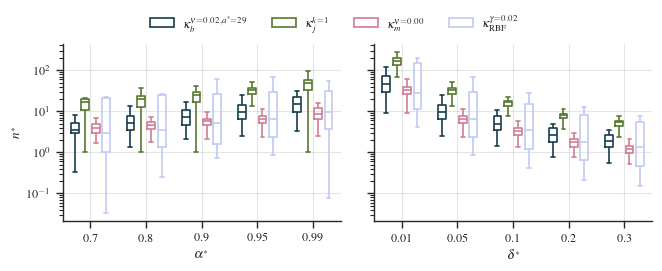

In [4]:
plotter.plot_nstar_on_alpha_delta(alpha_fixed=0.95, delta_fixed=0.05)

The second set of plots is the simulated experimental study for a specific configuration.
We run $N$ experiments (i.e., sample $N$ results from the experimental results), estimate the generalizability (top), and run a power-law regression to find $n^*_N$ (bottom).

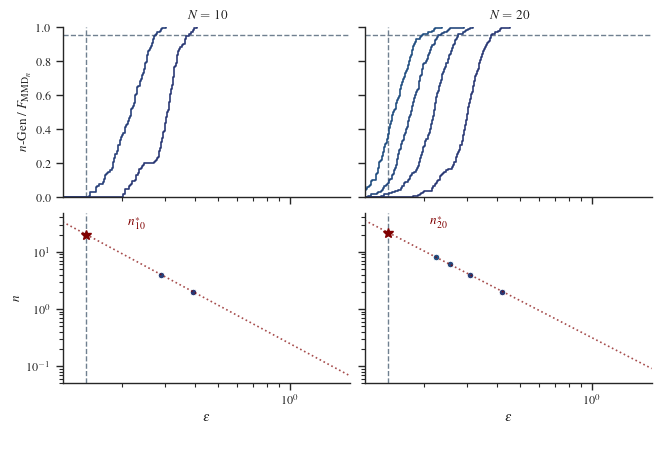

In [5]:
configuration = {"task_name": "arithmetic", "number_of_shots": 1}
kernels = [plotter.kernels[2]]
plotter.plot_simulated_experimental_study(configuration=configuration, alpha=0.95, delta=0.01, kernels=kernels)